# Desafío - Clasificación desde Machine Learning.
### Nombre: Thomas Peet, Braulio Aguila, Camilo Ramírez
### Generación: G47
### Profesores: Alfonso Tobar - Sebastián Ulloa
### Fecha: 25-07-2022

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels as sm
import statsmodels.api as sma
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, recall_score, f1_score, precision_score, plot_roc_curve, RocCurveDisplay, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.pipeline import Pipeline

In [48]:
df = pd.read_csv('default_credit.csv', index_col=0)
df.head()

,default,student,balance,income
index,,,,
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


Se observa que la data:
* No presenta datos nulos. 
* Consta de 4 variables: 2 categóricas y 2 numéricas.
* Son 10000 datos en total.

## Variables

* default: Variable binaria. Registra si el cliente entró en morosidad o no.
* income: Ingreso promedio declarado por el cliente.
* balance: Total de saldo en la cuenta de crédito.
* student: Variable binaria. Registra si el cliente es estudiante o no.

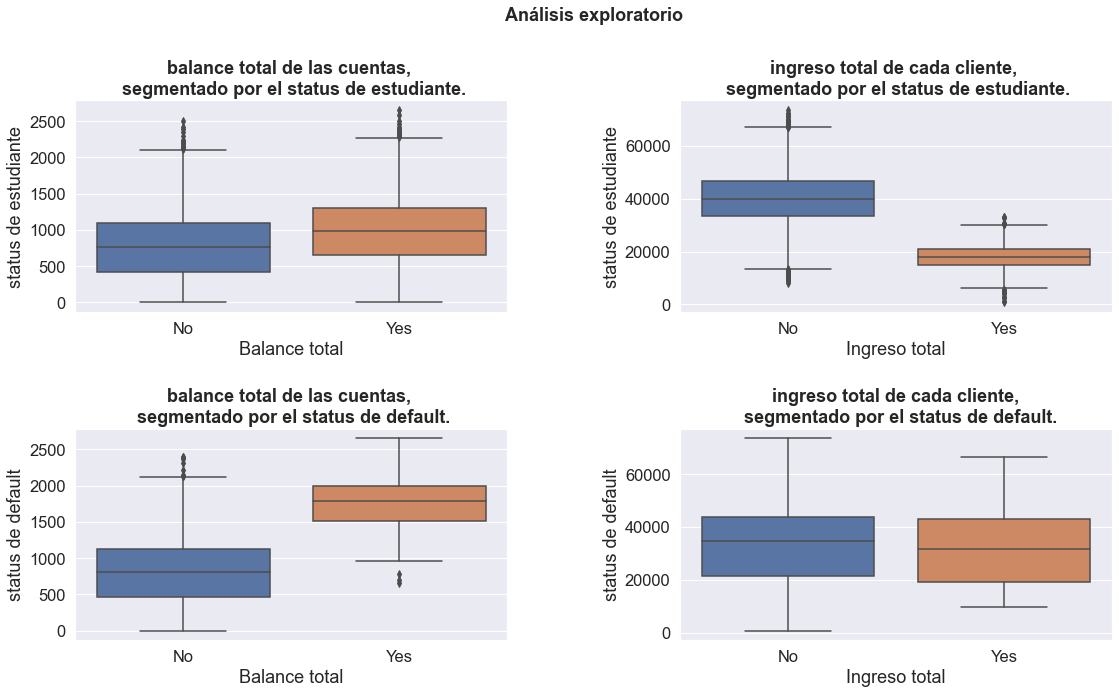

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Análisis exploratorio',  fontweight="bold", size=18)
ax = plt.gca()
titulos = [
    'balance total de las cuentas, \n segmentado por el status de estudiante.',
    'ingreso total de cada cliente, \n segmentado por el status de estudiante.',
    'balance total de las cuentas, \n segmentado por el status de default.',
    'ingreso total de cada cliente,\n  segmentado por el status de default.'
    ]
y_labels = [
    'Balance total',
    'Ingreso total',
    'Balance total',
    'Ingreso total',
]

x_labels = [
    'status de estudiante',
    'status de estudiante',
    'status de default',
    'status de default',
]

sns.set(font_scale = 1.5)
sns.boxplot(y='balance', x='student', data=df, ax=axes[0, 0])
sns.boxplot(ax = axes[0, 1], y='income', x='student', data=df)
sns.boxplot(ax = axes[1, 0], y='balance', x='default', data=df)
sns.boxplot(ax = axes[1 ,1], y='income', x='default', data=df)

for ax, titulo, x_l, y_l in zip(axes.reshape(-1),titulos, x_labels, y_labels):
    ax.set_title(titulo, fontweight="bold", size=18)
    ax.set_ylabel(x_l, fontsize=18)
    ax.set_xlabel(y_l, fontsize=18) 
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.55)
plt.show()


### Comentarios

Observamos que la variable 'income' ayuda a discriminar el valor que podría tener la variable categórica 'student'. Aparentemente la variable 'balance' no ayudaría a establecer un criterio de este tipo, ya que sus distribuciones se ven mucho más similares.

Este mismo tipo de relación se da pero de manera contraria entre la variable categórica 'default' y la variable 'balance'.

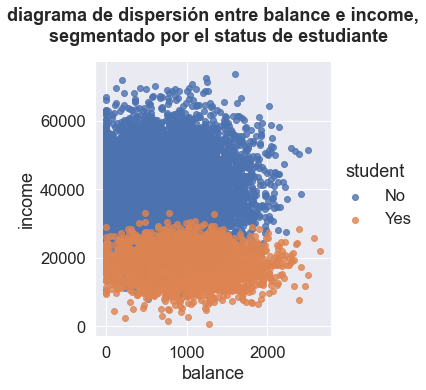

In [51]:
lm = sns.lmplot(x='balance', y='income', data=df, fit_reg=False, hue='student');
lm.fig.gca().set_title('diagrama de dispersión entre balance e income,\n  segmentado por el status de estudiante', fontweight="bold", size=18, pad=20);

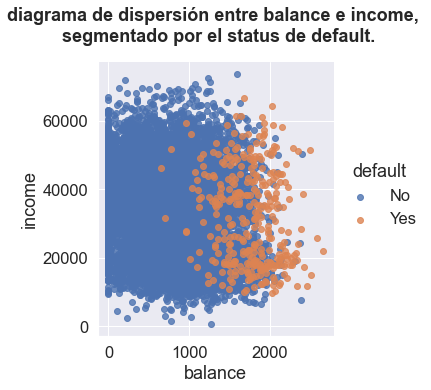

In [52]:
lm = sns.lmplot(x='balance', y='income', data=df, fit_reg=False, hue='default');
lm.fig.gca().set_title('diagrama de dispersión entre balance e income, \n segmentado por el status de default.',fontweight="bold", size=18, pad=20);

En el gráfico de dispersión entre balance e income separados por status de estudiante, se observa una frontera de decisión muy marcada en torno a los 27000 de la variable 'income'. Esto podría suponer que la capacidad de predicción del status de estudiante sería alta utilizando la variable income. Esto esta en concordancia con la obseración anterior.

En el segundo gráfico, se observa la misma nube de puntos, pero agrupada por status de morosidad (variable 'default'). Sin embargo la representación de los grupos queda solapada entre ellas cuando se agrupa entorno a la variable 'default'. Esto supondría una mayor dificultad al querer clasificar la variable 'default' utilizando los predictores 'income' y 'balance'.

In [53]:
target = ['default'] # target variable
predictors = ['student', 'balance', 'income'] # predictores iniciales
drop_columns = [] # columnas a eliminar
categorical = ['student','default'] # variables que son de tipo categóricas

categorical_wo_target = [elt for elt in categorical if elt not in target] # variables que son de tipo categóricas sin target
predictors = [elt for elt in predictors if elt not in drop_columns] # variables que son predictoras sin las columnas que se eliminan

df_dc = df.drop(columns = drop_columns) # eliminación de columnas que no se usarán del dataframe

ohe = SklearnTransformerWrapper(OrdinalEncoder(), variables=categorical)   # Definición del Encoder
sc = SklearnTransformerWrapper(StandardScaler(), variables=predictors)    # Definición del Scaler

df_ohe = ohe.fit_transform(df_dc)            # Encodear el dataframe

x = df_ohe.drop(columns=target)         # Eliminar la columna target
y = df_ohe[target[0]]                    # Seleccionar la columna target

x_sc = sc.fit_transform(x)             # Escalar el dataframe
X = sma.add_constant(x_sc)          # Agregar intercepto a los datos

model = sma.Logit(y, X).fit()      # Ajustar el modelo

print(f'AIC del modelo: {model.aic}')
print(f'BIC del modelo: {model.bic}')
model.summary()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10
AIC del modelo: 1579.5448275789595
BIC del modelo: 1608.3861890668643


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Mon, 25 Jul 2022   Pseudo R-squ.:                  0.4619
Time:                        20:46:12   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1657      0.190    -32.445      0.000      -6.538      -5.793
student       -0.2948      0.108     -2.738      0.006      -0.506      -0.084
balance        2.7747      0.112     24.737      0.000       2.555       2.995
income         0.0405      0.109      0.370      0.712      -0.174       0.255
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Se emplea el modelo de Regresión logística explicativo (del modulo statsmodels) para identificar variables poco significativas en la predicción de la variable 'default'. En primera instancia, se utilizaron las variables 'income', 'balance' y 'student' como predictores y se observó que el p-value de la variable 'income' era cercano a 0.7.  

Se falla en rechazar la hipotesis nula que indica que la variable predictora no tendría un efecto en la variable a predecir, por lo que en este caso, se acepta la hipótesis nula. Es decir, la variable 'income' no tendría un efecto sobre la variable 'default' en términos estadísticos.  

Descartamos el uso de esta variable dado lo antes expuesto

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # separación de los datos en train y test

pipe = Pipeline(steps=[
    ('ohe', SklearnTransformerWrapper(OrdinalEncoder(), variables=categorical_wo_target)), # Encoder
    ('sc', SklearnTransformerWrapper(StandardScaler(), variables=predictors)),             # Scaler
    ('lr', LogisticRegression())                                                           # Modelo
    ])

pipe.fit(X_train, y_train)                                                              # Entrenamiento del modelo

y_pred_train = pipe.predict(X_train)                                                   # Predicción del modelo sobre los datos de entrenamiento
y_pred = pipe.predict(X_test)                                                         # Predicción del modelo sobre los datos de test


print(f'Accuracy Entrenamiento: {accuracy_score(y_train, y_pred_train)}')   # Calcular la Precisión del modelo sobre los datos de entrenamiento
print(f'Accuracy Test: {accuracy_score(y_test, y_pred)}')             # Calcular la Precisión del modelo sobre los datos de test


Accuracy Entrenamiento: 0.9737313432835821
Accuracy Test: 0.973030303030303


Observamos que la Exactitud (Accuracy) en la predicción sobre los datos de entrenamiento es levemente superior a la precisión sobre los datos de test. Esto es esperable en modelos que no presentan mayor sobreajuste.

In [55]:
data1 = pipe.predict_proba(X_test)
data2 = np.array([pipe.predict(X_test)]).T
data3 = np.array([y_test]).T

data = np.append(data1, data2, axis=1)
data = np.append(data, data3, axis=1)
pd.DataFrame(data, columns = ['P(no default)','P(default)', 'Predicted', 'Real'])

,P(no default),P(default),Predicted,Real
0,0.929758,0.070242,0.0,0.0
1,0.998409,0.001591,0.0,0.0
2,0.999983,0.000017,0.0,0.0
3,0.999966,0.000034,0.0,0.0
4,0.953416,0.046584,0.0,0.0
...,...,...,...,...
3295,0.992939,0.007061,0.0,0.0
3296,0.976903,0.023097,0.0,0.0
3297,0.999700,0.000300,0.0,0.0
3298,0.277373,0.722627,1.0,0.0


In [56]:
def reporte(y_true, y_pred):
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'Precision: {precision_score(y_true, y_pred)}')
    print(f'Recall: {recall_score(y_true, y_pred)}')
    print(f'F1: {f1_score(y_true, y_pred)}')
    print(f'Confusion matrix: \n{  confusion_matrix(y_true, y_pred)}')
    print(f'Classification report: \n{classification_report(y_true, y_pred)}')

reporte(y_test, y_pred)

Precision: 0.7333333333333333
Accuracy: 0.973030303030303
Recall: 0.3
F1: 0.4258064516129032
Confusion matrix: 
[[3178   12]
 [  77   33]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3190
         1.0       0.73      0.30      0.43       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.71      3300
weighted avg       0.97      0.97      0.97      3300



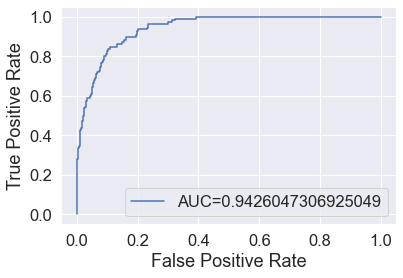

In [57]:
#define metrics
y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

La tarea que nos propusimos en un comienzo es predecir que personas serían morosas según su nivel de ingreso, balance y si eran estudiantes o no. Después del análisis exploratorio determinamos que el nivel de ingreso no era significativo para esta predicción por lo que fue desecho.

En este caso, tiene mayor relevancia clasificar correctamente a los sujetos que efectivamente serán morosos, más que a los que no. En este sentido las métricas recall y precision toman especial importancia ya que miden la capacidad del modelo para predecir especialmente los casos de clase 1, es decir los que son morosos.  

Según el valor de precision (0.73) del total de casos catalogados como morosos por el modelo solo el 73% lo son.

Según el valor del recall (0.3) del total de casos morosos solo el 30% fue catalogado como moroso por el modelo.

El valor de la métrica f1, que considera ambas métricas anteriores es de 0.426

Analizando estas métricas podemos concluir que nuestro modelo tiene una buena capacidad para predecir correctamente los casos que identifica como morosos, sin embargo no es tan bueno para encontrar todos los casos de morosidad.

La métrica accuracy, que mide el porcentaje de casos en que el modelo ha acertado no es tan útil en este caso, ya que su valor se sesga por la cantidad de casos de clase 'no moroso' bien predicho. Predecir esta clase correctamente no es el objetivo de nuestro modelo. Aunque esta métrica dio muy alta (0.97) no podemos confiarnos de este valor por lo ya explicado.

Respecto a la curva ROC, observamos que se obtiene un AUC (área bajo la curva) de un 0.94. Esto signfica que existe un 94% de probabilidad de clasificar correctamente al que es moroso escogida al azar. 